# ICA Decoding
### EEG Methods Version (over different types of ICA preprocessing)

This is adapted from Decodign PoS code to produce Figure 2 there. The load function has been altered to name a specific type of ICA preprocessing and the results are filtered to only load the relevant ones. Then instead of only plotting 3 lines w.r.t level of averaging, it also plots over 3 levels of ICA preprocessing (weak/strong/none).

In [1]:
# point the variable below to the folder containing the runs
# corresponding to the files which fit the template below:
# SVM_{len/freq/lexgram}_matched_avg{10/3/1}_window_size16_seed{N}.pkl

# under this location, there should be three folders with corresponding
# files in "len_matched_results" / "freq_matched_results" / "class..."

results_folder = "exp1_confound_corrected/"

In [28]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt
import pickle
import scipy
import pathlib
import re

from scipy.stats import binom_test
from scipy.signal import savgol_filter
from mne.stats import fdr_correction as fdr
from pathlib import Path


threshold = 0.05

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def load_run_results(identifier, confidence=0.95, smooth=True, ica=None, bc=None, return_raw=False, scaling='mnn',
                     specify_dir=None):
    """
    ica = [weak, none]
    bc = [sent_bc, no_bc, epoch_bc]
    """
    
    if not specify_dir:
    
        print('Pulling results: ', identifier)
        file_identifier = identifier.split('_avg')[0] + "_results"
        tmp_path = os.path.join(results_folder, file_identifier)
        print('checking for results in : ', tmp_path)
        files = os.listdir(tmp_path)

        # RE this
        extracted_runs = [x for x in files if "bestmodel" not in x]
        extracted_runs = [x for x in extracted_runs if "dev" not in x]
        extracted_runs = [x for x in extracted_runs if identifier in x]

        if scaling=='mnn':
            extracted_runs = [x for x in extracted_runs if "_ss" not in x]
        elif scaling=='ss':
            extracted_runs = [x for x in extracted_runs if "_ss" in x]

        if bc == "epoch_bc":
            extracted_runs = [x for x in extracted_runs if "epoch" in x]
        elif bc == "no_bc":
            extracted_runs = [x for x in extracted_runs if "no_bc" in x]
        elif bc == "sent_bc":
            extracted_runs = [x for x in extracted_runs if "sent" in x]
        else:
            raise Exception("bc type not understood")

        if ica == "none":
            extracted_runs = [x for x in extracted_runs if "none" in x]
        elif ica == "weak":
            extracted_runs = [x for x in extracted_runs if "weak" in x]
            
    else:
        tmp_path = os.path.join(results_folder, specify_dir)
        print('checking for results in : ', tmp_path)
        files = os.listdir(tmp_path)

        extracted_runs = os.listdir(os.path.join(results_folder, specify_dir))
        extracted_runs = [x for x in files if "bestmodel" not in x]
        extracted_runs = [x for x in extracted_runs if "dev" not in x]
        extracted_runs = [x for x in extracted_runs if identifier in x]

    print(extracted_runs)
    tmp = np.zeros((len(extracted_runs), 160))
                   
    for i, run in enumerate(extracted_runs):
        print('Extracted Run: ', run)
        tmp_run = pickle.load(open(os.path.join(tmp_path, run), 'rb'))
        tmp[i, :] = tmp_run
        
        #print(tmp_run)
        
    # TODO: vectorise this later
    low_val = []
    mean_val = []
    high_val = []

    for i in range(tmp.shape[1]):
        mid, low, high = mean_confidence_interval(tmp[:,i], confidence=0.68)
        low_val.append(low)
        mean_val.append(mid)
        high_val.append(high)
        
    low_val = np.array(low_val)
    mean_val = np.array(mean_val)
    high_val = np.array(high_val)

    if smooth:
        low_val = savgol_filter(low_val, window_length=11, polyorder=4)
        mean_val = savgol_filter(mean_val, window_length=11, polyorder=4)
        high_val = savgol_filter(high_val, window_length=11, polyorder=4)
    
    if return_raw:
        return low_val, mean_val, high_val, tmp
    else:
        return low_val, mean_val, high_val

def load_best_run(identifier, n_avg):
    """ Specify {len/freq/class} and what level of averaging and look
    in results folder highest scoring dev run, return test run with same seed """
    
    # expect format "len_matched_avg10_" (with trailing underscore)
    file_identifier = identifier.split('_avg')[0] + "_results"
    tmp_path = os.path.join(results_folder, file_identifier)
    runs = list(Path(tmp_path).glob(f'*avg{n_avg}_*dev*'))
    
    #print('checking files: ', runs)
    
    highest_dev_value = 0
    highest_dev_seed = -1
    
    for run in runs:
        #print(run)
        tmp_dev = pickle.load(open(run, 'rb'))
        tmp_max_dev = np.mean(tmp_dev)
        tmp_seed = str(re.search('seed(\d+)', run.stem).group(1))
        if tmp_max_dev > highest_dev_value:
            #print('highest: ', tmp_max_dev, tmp_seed)
            highest_dev_value = tmp_max_dev
            highest_dev_seed = tmp_seed
    
    # now load the corresponding test set
    test_file = list(Path(tmp_path).glob(f'*avg{n_avg}_*test*_seed{highest_dev_seed}*'))[0]
    #print(f'best test file: ', test_file)
    result = pickle.load(open(test_file, 'rb'))
    
    return np.array(result)

In [3]:
avg10_alpha = 1.0
avg3_alpha = 1.0
avg1_alpha = 0.5
n_time = 176

## Length (weak ICA - epoch bc - MNN)

checking for results in :  exp1_confound_corrected/len_matched_results/ica_weak_epoch_bc_mnn
['SVM_len_matched_avg1_window_size16_test_seed21_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed23_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed32_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed43_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed4_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed54_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed56_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed66_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed76_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed87_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed9_ica_ica_weak_epoch_bc_scores.p

Pulling results:  len_matched_avg10_
checking for results in :  exp1_confound_corrected/len_matched_results
['SVM_len_matched_avg10_window_size16_test_seed21_ica_weak_sent_bc_only_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed21_ica_weak_sent_bc_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed23_ica_weak_sent_bc_only_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed23_ica_weak_sent_bc_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed43_ica_weak_sent_bc_only_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed43_ica_weak_sent_bc_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed4_ica_weak_sent_bc_only_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed4_ica_weak_sent_bc_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed54_ica_weak_sent_bc_only_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed54_ica_weak_sent_bc_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed56_ica_weak_sent_bc_only_scores.

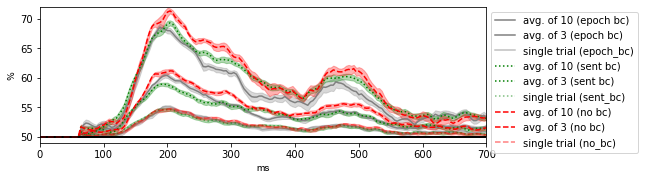

In [29]:
# ---- Needed for all plots
fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)
# -------------------------

# Epoch-level BC

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='epoch_bc', specify_dir="len_matched_results/ica_weak_epoch_bc_mnn")
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='epoch_bc', specify_dir="len_matched_results/ica_weak_epoch_bc_mnn")
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='epoch_bc', specify_dir="len_matched_results/ica_weak_epoch_bc_mnn")

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1_weak)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='grey', alpha=avg10_alpha, label='avg. of 10 (epoch bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3 (epoch bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial (epoch_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,70)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------

# Sentence-level bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='sent_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='sent_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='sent_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='g', alpha=avg10_alpha, linestyle=':', label='avg. of 10 (sent bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='g', alpha=avg3_alpha, linestyle=':', label='avg. of 3 (sent bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='g', alpha=avg1_alpha, linestyle=':', label='single trial (sent_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='g', alpha=0.3)

axes[0].set_ylim(49,70)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------

# No bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='no_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='no_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='no_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='r', alpha=avg10_alpha, linestyle='--',  label='avg. of 10 (no bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='r', alpha=avg3_alpha, linestyle='--', label='avg. of 3 (no bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='r', alpha=avg1_alpha, linestyle='--', label='single trial (no_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='r', alpha=0.3)

axes[0].set_ylim(49,72)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# ---------------

plt.legend(bbox_to_anchor=[1,1])


#import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['svg.fonttype'] = 'none'
#matplotlib.rcParams['font.family'] = 'Arial'

#plt.style.use('default')
#plt.savefig('exp1_fig1_len_decoding.svg', format='svg')
#plt.savefig('exp1_fig1_len_decoding.pdf', format='pdf')

# Freq (weak ICA)

Pulling results:  freq_matched_avg1_
checking for results in :  exp1_confound_corrected/freq_matched_results
['SVM_freq_matched_avg1_window_size16_test_seed21_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed23_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed43_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed4_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed54_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed56_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed66_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed76_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed87_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_freq_matched_avg1_window_size16_test_seed9_ica_ica_weak_epoch_bc_scores.pkl']
Extracted Run:  SVM_freq_matched_avg1_window_size16_

Pulling results:  freq_matched_avg10_
checking for results in :  exp1_confound_corrected/freq_matched_results
['SVM_freq_matched_avg10_window_size16_test_seed21_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed23_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed43_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed4_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed54_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed56_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed66_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed76_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed87_ica_ica_weak_sent_bc_scores.pkl', 'SVM_freq_matched_avg10_window_size16_test_seed9_ica_ica_weak_sent_bc_scores.pkl']
Extracted Run:  SVM_freq_matched_avg10_window_size1

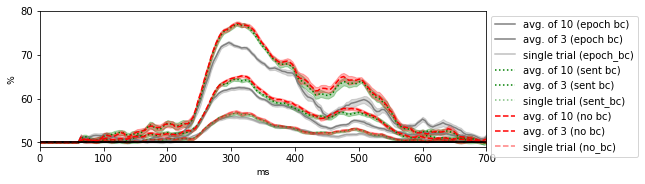

In [8]:
# ---- Needed for all plots
fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)
# -------------------------

# Epoch-level BC

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('freq_matched_avg1_', ica='weak', bc='epoch_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('freq_matched_avg3_', ica='weak', bc='epoch_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('freq_matched_avg10_', ica='weak', bc='epoch_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1_weak)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='grey', alpha=avg10_alpha, label='avg. of 10 (epoch bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3 (epoch bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial (epoch_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,80)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------

# Sentence-level bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('freq_matched_avg1_', ica='weak', bc='sent_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('freq_matched_avg3_', ica='weak', bc='sent_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('freq_matched_avg10_', ica='weak', bc='sent_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='g', alpha=avg10_alpha, linestyle=':', label='avg. of 10 (sent bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='g', alpha=avg3_alpha, linestyle=':', label='avg. of 3 (sent bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='g', alpha=avg1_alpha, linestyle=':', label='single trial (sent_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='g', alpha=0.3)


# --------

# No bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('freq_matched_avg1_', ica='weak', bc='no_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('freq_matched_avg3_', ica='weak', bc='no_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('freq_matched_avg10_', ica='weak', bc='no_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='r', alpha=avg10_alpha, linestyle='--',  label='avg. of 10 (no bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='r', alpha=avg3_alpha, linestyle='--', label='avg. of 3 (no bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='r', alpha=avg1_alpha, linestyle='--', label='single trial (no_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='r', alpha=0.3)


# ---------------

plt.legend(bbox_to_anchor=[1,1])


#import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['svg.fonttype'] = 'none'
#matplotlib.rcParams['font.family'] = 'Arial'

#plt.style.use('default')
#plt.savefig('exp1_fig1_len_decoding.svg', format='svg')
#plt.savefig('exp1_fig1_len_decoding.pdf', format='pdf')

# Class (Weak ICA)

Pulling results:  class_matched_avg1_
checking for results in :  exp1_confound_corrected/class_matched_results
['SVM_class_matched_avg1_window_size16_test_seed21_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed23_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed43_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed4_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed54_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed56_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed66_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed76_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed87_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed9_ica_ica_weak_epoch_bc_scores.pkl']
Extracted Run:  SVM_class_matched_avg1_w

Pulling results:  class_matched_avg10_
checking for results in :  exp1_confound_corrected/class_matched_results
['SVM_class_matched_avg10_window_size16_test_seed21_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed23_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed43_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed4_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed54_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed56_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed66_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed76_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed87_ica_weak_sent_bc_only_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed9_ica_weak_sent_bc_only_scores.pkl']
Extracted Run:  SVM_class_mat

Pulling results:  class_matched_avg10_
checking for results in :  exp1_confound_corrected/class_matched_results
['SVM_class_matched_avg10_window_size16_test_seed21_ica_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed21_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed23_ica_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed23_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed32_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed43_ica_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed43_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed4_ica_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed4_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed54_ica_ica_weak_no_bc_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed54_ica_weak_no_bc_scores.pkl', 

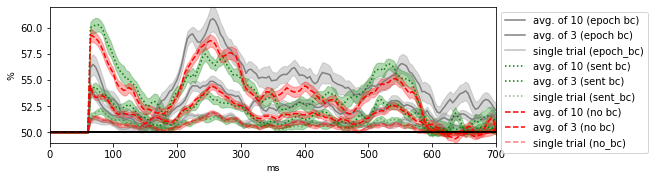

In [14]:
# ---- Needed for all plots
fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)
# -------------------------

# Epoch-level BC

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('class_matched_avg1_', ica='weak', bc='epoch_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('class_matched_avg3_', ica='weak', bc='epoch_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('class_matched_avg10_', ica='weak', bc='epoch_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1_weak)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='grey', alpha=avg10_alpha, label='avg. of 10 (epoch bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3 (epoch bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial (epoch_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,62)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------

# Sentence-level bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('class_matched_avg1_', ica='weak', bc='sent_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('class_matched_avg3_', ica='weak', bc='sent_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('class_matched_avg10_', ica='weak', bc='sent_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='g', alpha=avg10_alpha, linestyle=':', label='avg. of 10 (sent bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='g', alpha=avg3_alpha, linestyle=':', label='avg. of 3 (sent bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='g', alpha=avg1_alpha, linestyle=':', label='single trial (sent_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='g', alpha=0.3)


# --------

# No bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('class_matched_avg1_', ica='weak', bc='no_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('class_matched_avg3_', ica='weak', bc='no_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('class_matched_avg10_', ica='weak', bc='no_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='r', alpha=avg10_alpha, linestyle='--',  label='avg. of 10 (no bc)')
axes[0].plot(x, scores_pad_avg3_weak, color='r', alpha=avg3_alpha, linestyle='--', label='avg. of 3 (no bc)')
axes[0].plot(x, scores_pad_avg1_weak, color='r', alpha=avg1_alpha, linestyle='--', label='single trial (no_bc)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='r', alpha=0.3)


# ---------------

plt.legend(bbox_to_anchor=[1,1])


#import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['svg.fonttype'] = 'none'
#matplotlib.rcParams['font.family'] = 'Arial'

#plt.style.use('default')
#plt.savefig('exp1_fig1_len_decoding.svg', format='svg')
#plt.savefig('exp1_fig1_len_decoding.pdf', format='pdf')

# Class (Weak ICA - MNN vs SS)

Pulling results:  class_matched_avg1_
checking for results in :  exp1_confound_corrected/class_matched_results
['SVM_class_matched_avg1_window_size16_test_seed21_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed23_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed43_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed4_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed54_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed56_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed66_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed76_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed87_ica_ica_weak_epoch_bc_scores.pkl', 'SVM_class_matched_avg1_window_size16_test_seed9_ica_ica_weak_epoch_bc_scores.pkl']
Extracted Run:  SVM_class_matched_avg1_w

['SVM_class_matched_avg10_window_size16_test_seed21_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed23_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed43_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed4_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed54_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed56_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed66_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed76_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed87_ica_ica_weak_epoch_bc_ss_scores.pkl', 'SVM_class_matched_avg10_window_size16_test_seed9_ica_ica_weak_epoch_bc_ss_scores.pkl']
Extracted Run:  SVM_class_matched_avg10_window_size16_test_seed21_ica_ica_weak_epoch_bc_ss_scores.pkl
Extracted

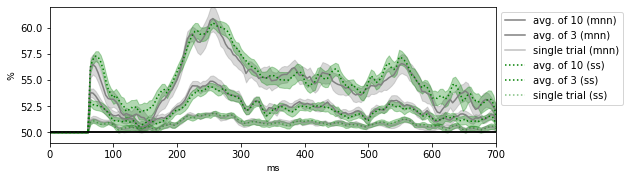

In [18]:
# ---- Needed for all plots
fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)
# -------------------------

# Epoch-level BC

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('class_matched_avg1_', ica='weak', bc='epoch_bc')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('class_matched_avg3_', ica='weak', bc='epoch_bc')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('class_matched_avg10_', ica='weak', bc='epoch_bc')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1_weak)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='grey', alpha=avg10_alpha, label='avg. of 10 (mnn)')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3 (mnn)')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial (mnn)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,62)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------

# Sentence-level bc

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('class_matched_avg1_', ica='weak', bc='epoch_bc', scaling='ss')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('class_matched_avg3_', ica='weak', bc='epoch_bc', scaling='ss')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('class_matched_avg10_', ica='weak', bc='epoch_bc', scaling='ss')

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='g', alpha=avg10_alpha, linestyle=':', label='avg. of 10 (ss)')
axes[0].plot(x, scores_pad_avg3_weak, color='g', alpha=avg3_alpha, linestyle=':', label='avg. of 3 (ss)')
axes[0].plot(x, scores_pad_avg1_weak, color='g', alpha=avg1_alpha, linestyle=':', label='single trial (ss)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='g', alpha=0.3)
# ---------------
plt.legend(bbox_to_anchor=[1,1])

# Len (sent_bc) MNN vs SS

checking for results in :  exp1_confound_corrected/len_matched_results/ica_weak_no_bc_mnn
['SVM_len_matched_avg1_window_size16_test_seed21_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed23_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed43_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed4_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed54_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed56_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed66_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed76_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed87_ica_weak_no_bc_mnn_scores.pkl', 'SVM_len_matched_avg1_window_size16_test_seed9_ica_weak_no_bc_mnn_scores.pkl']
Extracted Run:  SVM_len_matched_avg1_window_size16_test_seed21_ica_weak_no_bc_mnn_scores.pkl
Extracted Run:  SV

checking for results in :  exp1_confound_corrected/len_matched_results/ica_weak_no_bc_ss
['SVM_len_matched_avg10_window_size16_test_seed21_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed23_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed43_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed4_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed54_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed56_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed66_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed76_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed87_ica_weak_no_bc_ss_scores.pkl', 'SVM_len_matched_avg10_window_size16_test_seed9_ica_weak_no_bc_ss_scores.pkl']
Extracted Run:  SVM_len_matched_avg10_window_size16_test_seed21_ica_weak_no_bc_ss_scores.pkl
Extracted Run:  SVM

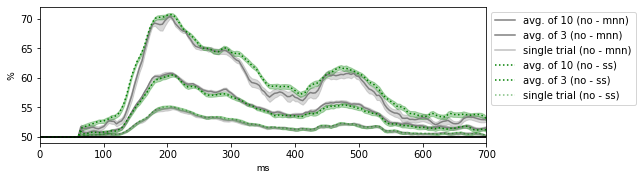

In [35]:
# Weak epoch_bc mnn (already got results)
# Weak epoch_bc ss (currently running)
# Weak no_bc mnn (already got results)
# Weak no_bc ss (need to do)

# ---- Needed for all plots
fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)
# -------------------------

# Epoch-level BC
# MNN

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='epoch_bc', specify_dir="len_matched_results/ica_weak_no_bc_mnn")
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='epoch_bc', specify_dir="len_matched_results/ica_weak_no_bc_mnn")
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='epoch_bc', specify_dir="len_matched_results/ica_weak_no_bc_mnn")

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1_weak)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='grey', alpha=avg10_alpha, label='avg. of 10 (no - mnn)')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3 (no - mnn)')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial (no - mnn)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,70)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------
# Epoch level BC
# SS

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='sent_bc', specify_dir="len_matched_results/ica_weak_no_bc_ss")
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='sent_bc', specify_dir="len_matched_results/ica_weak_no_bc_ss")
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='sent_bc', specify_dir="len_matched_results/ica_weak_no_bc_ss")

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='g', alpha=avg10_alpha, linestyle=':', label='avg. of 10 (no - ss)')
axes[0].plot(x, scores_pad_avg3_weak, color='g', alpha=avg3_alpha, linestyle=':', label='avg. of 3 (no - ss)')
axes[0].plot(x, scores_pad_avg1_weak, color='g', alpha=avg1_alpha, linestyle=':', label='single trial (no - ss)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='g', alpha=0.3)

axes[0].set_ylim(49,72)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------
# -------------------------
"""
# No BC
# MNN

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='epoch_bc', specify_dir="ica_weak_no_bc_mnn")
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='epoch_bc', specify_dir="ica_weak_no_bc_mnn")
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='epoch_bc', specify_dir="ica_weak_no_bc_mnn")

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1_weak)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='grey', alpha=avg10_alpha, label='avg. of 10 (epoch - mnn)')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3 (epoch - mnn)')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial (epoch - mnn)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,70)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------

# No BC
# SS

len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('len_matched_avg1_', ica='weak', bc='sent_bc', specify_dir="len_results/ica_weak_no_bc_ss")
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('len_matched_avg3_', ica='weak', bc='sent_bc', specify_dir="len_results/ica_weak_no_bc_ss")
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('len_matched_avg10_', ica='weak', bc='sent_bc', specify_dir="len_results/ica_weak_no_bc_ss")

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='g', alpha=avg10_alpha, linestyle=':', label='avg. of 10 (epoch - ss)')
axes[0].plot(x, scores_pad_avg3_weak, color='g', alpha=avg3_alpha, linestyle=':', label='avg. of 3 (epoch - ss)')
axes[0].plot(x, scores_pad_avg1_weak, color='g', alpha=avg1_alpha, linestyle=':', label='single trial (epoch - ss)')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='g', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='g', alpha=0.3)

axes[0].set_ylim(49,70)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')
# ---------------
"""
plt.legend(bbox_to_anchor=[1,1])


## Frequency

In [ ]:
len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('freq_matched_avg1_', ica='weak')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('freq_matched_avg3_', ica='weak')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('freq_matched_avg10_', ica='weak')

fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='k', alpha=avg10_alpha, label='avg. of 10')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,70)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------
len_ws16_avg1_low_strong, len_ws16_avg1_strong, len_ws16_avg1_high_strong = load_run_results('freq_matched_avg1_', ica='strong')
len_ws16_avg3_low_strong, len_ws16_avg3_strong, len_ws16_avg3_high_strong = load_run_results('freq_matched_avg3_', ica='strong')
len_ws16_avg10_low_strong, len_ws16_avg10_strong, len_ws16_avg10_high_strong = load_run_results('freq_matched_avg10_', ica='strong')

scores_avg1_strong = len_ws16_avg1_strong
scores_avg3_strong = len_ws16_avg3_strong
scores_avg10_strong =len_ws16_avg10_strong

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_strong = np.array(np.concatenate([pad, scores_avg1_strong])) * 100
scores_pad_avg3_strong = np.array(np.concatenate([pad, scores_avg3_strong])) * 100
scores_pad_avg10_strong = np.array(np.concatenate([pad, scores_avg10_strong])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_strong, color='r', alpha=avg10_alpha, label='avg. of 10')
axes[0].plot(x, scores_pad_avg3_strong, color='r', alpha=avg3_alpha, label='avg. of 3')
axes[0].plot(x, scores_pad_avg1_strong, color='r', alpha=avg1_alpha, label='single trial')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_strong= np.array(np.concatenate([pad, len_ws16_avg1_low_strong])) * 100
low_pad_avg3_strong = np.array(np.concatenate([pad, len_ws16_avg3_low_strong])) * 100
low_pad_avg10_strong = np.array(np.concatenate([pad, len_ws16_avg10_low_strong])) * 100
high_pad_avg1_strong = np.array(np.concatenate([pad, len_ws16_avg1_high_strong])) * 100
high_pad_avg3_strong = np.array(np.concatenate([pad, len_ws16_avg3_high_strong])) * 100
high_pad_avg10_strong = np.array(np.concatenate([pad, len_ws16_avg10_high_strong])) * 100

axes[0].fill_between(x, low_pad_avg1_strong, high_pad_avg1_strong, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_strong, high_pad_avg3_strong, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_strong, high_pad_avg10_strong, color='r', alpha=0.3)

# ---------------------------

len_ws16_avg1_low_none, len_ws16_avg1_none, len_ws16_avg1_high_none = load_run_results('freq_matched_avg1_', ica='none')
len_ws16_avg3_low_none, len_ws16_avg3_none, len_ws16_avg3_high_none = load_run_results('freq_matched_avg3_', ica='none')
len_ws16_avg10_low_none, len_ws16_avg10_none, len_ws16_avg10_high_none = load_run_results('freq_matched_avg10_', ica='none')

scores_avg1_none = len_ws16_avg1_none
scores_avg3_none = len_ws16_avg3_none
scores_avg10_none =len_ws16_avg10_none

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_none = np.array(np.concatenate([pad, scores_avg1_none])) * 100
scores_pad_avg3_none = np.array(np.concatenate([pad, scores_avg3_none])) * 100
scores_pad_avg10_none = np.array(np.concatenate([pad, scores_avg10_none])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_none, color='b', alpha=avg10_alpha, label='avg. of 10')
axes[0].plot(x, scores_pad_avg3_none, color='b', alpha=avg3_alpha, label='avg. of 3')
axes[0].plot(x, scores_pad_avg1_none, color='b', alpha=avg1_alpha, label='single trial')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_none = np.array(np.concatenate([pad, len_ws16_avg1_low_none])) * 100
low_pad_avg3_none = np.array(np.concatenate([pad, len_ws16_avg3_low_none])) * 100
low_pad_avg10_none = np.array(np.concatenate([pad, len_ws16_avg10_low_none])) * 100
high_pad_avg1_none = np.array(np.concatenate([pad, len_ws16_avg1_high_none])) * 100
high_pad_avg3_none = np.array(np.concatenate([pad, len_ws16_avg3_high_none])) * 100
high_pad_avg10_none = np.array(np.concatenate([pad, len_ws16_avg10_high_none])) * 100

axes[0].fill_between(x, low_pad_avg1_none, high_pad_avg1_none, color='b', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_none, high_pad_avg3_none, color='b', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_none, high_pad_avg10_none, color='b', alpha=0.3)

## Class

In [ ]:
len_ws16_avg1_low_weak, len_ws16_avg1_weak, len_ws16_avg1_high_weak = load_run_results('class_matched_avg1_', ica='weak')
len_ws16_avg3_low_weak, len_ws16_avg3_weak, len_ws16_avg3_high_weak = load_run_results('class_matched_avg3_', ica='weak')
len_ws16_avg10_low_weak, len_ws16_avg10_weak, len_ws16_avg10_high_weak = load_run_results('class_matched_avg10_', ica='weak')

fig, axes = plt.subplots(1,1, figsize=(8,2.5))
axes = np.ravel(axes)

scores_avg1_weak = len_ws16_avg1_weak
scores_avg3_weak = len_ws16_avg3_weak
scores_avg10_weak =len_ws16_avg10_weak

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_weak = np.array(np.concatenate([pad, scores_avg1_weak])) * 100
scores_pad_avg3_weak = np.array(np.concatenate([pad, scores_avg3_weak])) * 100
scores_pad_avg10_weak = np.array(np.concatenate([pad, scores_avg10_weak])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_weak, color='k', alpha=avg10_alpha, label='avg. of 10')
axes[0].plot(x, scores_pad_avg3_weak, color='grey', alpha=avg3_alpha, label='avg. of 3')
axes[0].plot(x, scores_pad_avg1_weak, color='grey', alpha=avg1_alpha, label='single trial')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_low_weak])) * 100
low_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_low_weak])) * 100
low_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_low_weak])) * 100
high_pad_avg1_weak = np.array(np.concatenate([pad, len_ws16_avg1_high_weak])) * 100
high_pad_avg3_weak = np.array(np.concatenate([pad, len_ws16_avg3_high_weak])) * 100
high_pad_avg10_weak = np.array(np.concatenate([pad, len_ws16_avg10_high_weak])) * 100

axes[0].fill_between(x, low_pad_avg1_weak, high_pad_avg1_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_weak, high_pad_avg3_weak, color='grey', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_weak, high_pad_avg10_weak, color='grey', alpha=0.3)

axes[0].set_ylim(49,60)
axes[0].set_xlim(0,700)
axes[0].set_ylabel('%', fontname='Arial')
axes[0].set_xlabel('ms', fontname='Arial')

# --------------------
len_ws16_avg1_low_strong, len_ws16_avg1_strong, len_ws16_avg1_high_strong = load_run_results('class_matched_avg1_', ica='strong')
len_ws16_avg3_low_strong, len_ws16_avg3_strong, len_ws16_avg3_high_strong = load_run_results('class_matched_avg3_', ica='strong')
len_ws16_avg10_low_strong, len_ws16_avg10_strong, len_ws16_avg10_high_strong = load_run_results('class_matched_avg10_', ica='strong')

scores_avg1_strong = len_ws16_avg1_strong
scores_avg3_strong = len_ws16_avg3_strong
scores_avg10_strong =len_ws16_avg10_strong

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_strong = np.array(np.concatenate([pad, scores_avg1_strong])) * 100
scores_pad_avg3_strong = np.array(np.concatenate([pad, scores_avg3_strong])) * 100
scores_pad_avg10_strong = np.array(np.concatenate([pad, scores_avg10_strong])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_strong, color='r', alpha=avg10_alpha, label='avg. of 10')
axes[0].plot(x, scores_pad_avg3_strong, color='r', alpha=avg3_alpha, label='avg. of 3')
axes[0].plot(x, scores_pad_avg1_strong, color='r', alpha=avg1_alpha, label='single trial')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_strong= np.array(np.concatenate([pad, len_ws16_avg1_low_strong])) * 100
low_pad_avg3_strong = np.array(np.concatenate([pad, len_ws16_avg3_low_strong])) * 100
low_pad_avg10_strong = np.array(np.concatenate([pad, len_ws16_avg10_low_strong])) * 100
high_pad_avg1_strong = np.array(np.concatenate([pad, len_ws16_avg1_high_strong])) * 100
high_pad_avg3_strong = np.array(np.concatenate([pad, len_ws16_avg3_high_strong])) * 100
high_pad_avg10_strong = np.array(np.concatenate([pad, len_ws16_avg10_high_strong])) * 100

axes[0].fill_between(x, low_pad_avg1_strong, high_pad_avg1_strong, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_strong, high_pad_avg3_strong, color='r', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_strong, high_pad_avg10_strong, color='r', alpha=0.3)

# ---------------------------

len_ws16_avg1_low_none, len_ws16_avg1_none, len_ws16_avg1_high_none = load_run_results('class_matched_avg1_', ica='none')
len_ws16_avg3_low_none, len_ws16_avg3_none, len_ws16_avg3_high_none = load_run_results('class_matched_avg3_', ica='none')
len_ws16_avg10_low_none, len_ws16_avg10_none, len_ws16_avg10_high_none = load_run_results('class_matched_avg10_', ica='none')

scores_avg1_none = len_ws16_avg1_none
scores_avg3_none = len_ws16_avg3_none
scores_avg10_none =len_ws16_avg10_none

x = np.linspace(0, 700, n_time)
chance = np.array([0.5] * len(x))
n_pad = n_time - len(scores_avg1)
n_pad_half = int(n_pad // 2)

# Need to padd vector
pad = np.array([0.5] * n_pad)
scores_pad_avg1_none = np.array(np.concatenate([pad, scores_avg1_none])) * 100
scores_pad_avg3_none = np.array(np.concatenate([pad, scores_avg3_none])) * 100
scores_pad_avg10_none = np.array(np.concatenate([pad, scores_avg10_none])) * 100
chance = np.array(chance) * 100

axes[0].plot(x, scores_pad_avg10_none, color='b', alpha=avg10_alpha, label='avg. of 10')
axes[0].plot(x, scores_pad_avg3_none, color='b', alpha=avg3_alpha, label='avg. of 3')
axes[0].plot(x, scores_pad_avg1_none, color='b', alpha=avg1_alpha, label='single trial')

axes[0].axhline(50, linestyle='-', color='black', alpha=1.0)

# Add in confidence intervals
low_pad_avg1_none = np.array(np.concatenate([pad, len_ws16_avg1_low_none])) * 100
low_pad_avg3_none = np.array(np.concatenate([pad, len_ws16_avg3_low_none])) * 100
low_pad_avg10_none = np.array(np.concatenate([pad, len_ws16_avg10_low_none])) * 100
high_pad_avg1_none = np.array(np.concatenate([pad, len_ws16_avg1_high_none])) * 100
high_pad_avg3_none = np.array(np.concatenate([pad, len_ws16_avg3_high_none])) * 100
high_pad_avg10_none = np.array(np.concatenate([pad, len_ws16_avg10_high_none])) * 100

axes[0].fill_between(x, low_pad_avg1_none, high_pad_avg1_none, color='b', alpha=0.3)
axes[0].fill_between(x, low_pad_avg3_none, high_pad_avg3_none, color='b', alpha=0.3)
axes[0].fill_between(x, low_pad_avg10_none, high_pad_avg10_none, color='b', alpha=0.3)

# Load ERPs

Load the MNE training data for each confound-corrected variable and use the `joint_plot` function to plot a joint ERP-topography plot, which will be used in producing Figure 2.


In [ ]:
lex_description = 'pos == "NOUN" or pos == "VERB" or pos == "ADJ" or pos == "PROPN" or pos == "ADV"'
gram_description = 'pos == "ADP" or pos == "DET" or pos == "PRON" or pos == "AUX" or pos == "SCONJ" or pos == "CCONJ"'
short_description = 'len <= 4'
long_description = 'len > 4'
hf_description = 'freq > 5.91'
lf_description = 'freq <= 5.91'


In [ ]:
len_eeg = mne.read_epochs('len_matched_epochs_train-epo.fif')
len_eeg_dev = mne.read_epochs('len_matched_epochs_dev-epo.fif')
len_eeg_test = mne.read_epochs('len_matched_epochs_test-epo.fif')

len_eeg = mne.concatenate_epochs([len_eeg, len_eeg_dev, len_eeg_test])

freq_eeg = mne.read_epochs('freq_matched_epochs_train-epo.fif')
freq_eeg_dev = mne.read_epochs('freq_matched_epochs_dev-epo.fif')
freq_eeg_test = mne.read_epochs('freq_matched_epochs_test-epo.fif')

freq_eeg = mne.concatenate_epochs([freq_eeg, freq_eeg_dev, freq_eeg_test])

class_eeg = mne.read_epochs('class_matched_epochs_train-epo.fif')
class_eeg_dev = mne.read_epochs('class_matched_epochs_dev-epo.fif')
class_eeg_test = mne.read_epochs('class_matched2_epochs_test-epo.fif')

class_eeg = mne.concatenate_epochs([class_eeg, class_eeg_dev, class_eeg_test])

In [ ]:
short = len_eeg[short_description]
long = len_eeg[long_description]
short_avg = short.average()
long_avg = long.average()

hf = freq_eeg[hf_description]
lf = freq_eeg[lf_description]
hf_avg = hf.average()
lf_avg = lf.average()

lex = class_eeg[lex_description]
gram = class_eeg[gram_description]
lex_avg = lex.average()
gram_avg = gram.average()

In [ ]:
# Length

combined_evoked = mne.combine_evoked([short_avg, -long_avg], weights='equal')

topomap_args={'extrapolate':'local',
             'outlines':'skirt',
              'sphere':.13,
              'vmin':-0.5,
                 'vmax':0.5}

res = combined_evoked.plot_joint(
    title="Long > Short",
    #times=[00.18],
    ts_args={'ylim':dict(eeg=[-0.47, 0.68])},
    topomap_args=topomap_args);

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
res.savefig('len_diff_jointplot.svg', transparent=False, format='svg')

In [ ]:
# Frequency 

combined_evoked = mne.combine_evoked([hf_avg, -lf_avg], weights='equal')

topomap_args={'extrapolate':'local',
             'outlines':'skirt',
              'sphere':.13,
              'vmin':-0.7,
                 'vmax':0.7}

res = combined_evoked.plot_joint(
    title="High-Frequency > Low-Frequency",
    ts_args={'ylim':dict(eeg=[-0.6, 1.1])},
    topomap_args=topomap_args);

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
res.savefig('freq_diff_jointplot.svg', transparent=False, format='svg')

In [ ]:
# Class

topomap_args={'extrapolate':'local',
             'outlines':'skirt',
              'sphere':.13,
              'vmin':-0.3,
                 'vmax':0.3}

combined_evoked = mne.combine_evoked([-lex_avg, gram_avg], weights='equal')
res = combined_evoked.plot_joint(
    title="Open-class > Closed-class",
    times=[0.212,0.392],
    ts_args={'ylim':dict(eeg=[-0.35, 0.5])},
    topomap_args=topomap_args);

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
res.savefig('class_diff_jointplot.svg', transparent=False, format='svg')